In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3,0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3,0


In [7]:
import sys
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import spectral_clustering
from sklearn.svm import SVC
import os

# requires pytorch > 0.3.1
try:
  import torch
  import torch.nn as nn
  from torch.autograd import Variable
except ModuleNotFoundError:
  pass

# import the code, add path first
# for example
solver_path = 'D:\local_github\notebook\AffinityNet'
if os.path.exists(solver_path):
   sys.path.append(solver_path)

try:
  from AffinityNet.utils.solver import Solver
  from AffinityNet.affinitynet.graph_attention import *
  from AffinityNet.affinitynet.test_graph_attention import *
except ModuleNotFoundError:
  pass

%load_ext autoreload
%autoreload 2
#%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
use_gpu = True
if torch.cuda.is_available() and use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [9]:
seed = 0
signal_dim = 1
noisy_dim = 20
clu_size = 1000
num_clusters = 4
hidden_dims = [100]
num_iter = 100
batch_size = 100
lr = 1e-1
weight_decay = 1e-4
root = '.'
save_folder_prefix = '{0}/data/simulation/knn_pooling_toy/seed{1}'.format(root, seed)
# if not os.path.exists(save_folder_prefix):
#   os.makedirs(save_folder_prefix)
save_fig = False
figsize = 10

y: 4000
y: [0. 0. 0. ... 3. 3. 3.]


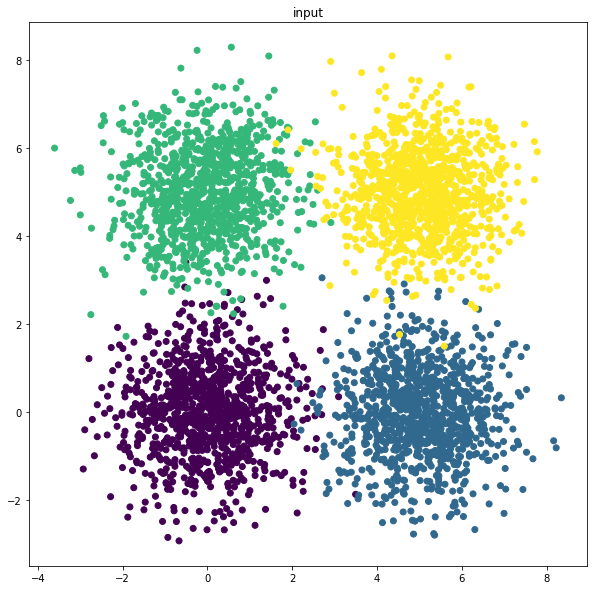

In [35]:
means = np.array([[0,0], [1,0], [0,1], [1,1]]) * 5
assert num_clusters == len(means)
means = [m*signal_dim for m in means]
sigmas = 1.0*np.ones(len(means))
x = []
y = []
for i, (mean, sigma) in enumerate(zip(means, sigmas)):
    x.append(np.random.multivariate_normal(mean, sigma*np.eye(len(mean)), size=clu_size))
    y.append(i*np.ones(clu_size))
x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0)

print("y:",len(y))
print("y:",y)

title = 'input'
plt.figure(figsize=(figsize, figsize))
plt.scatter(x[:,0], x[:,1], c=y)
save_folder = save_folder_prefix
if save_fig:
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
else:
    plt.title(title)
    plt.show()
plt.close()

In [63]:
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sklearn.metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import spectral_clustering, KMeans

import torch
import torch.nn as nn
from torch.autograd import Variable

if torch.cuda.is_available():
  dtype = {'float': torch.cuda.FloatTensor, 'long': torch.cuda.LongTensor, 'byte': torch.cuda.ByteTensor} 
else:
  dtype = {'float': torch.FloatTensor, 'long': torch.LongTensor, 'byte': torch.ByteTensor} 


def pca(x, n_components=2, verbose=False):
    r"""PCA for 2-D visualization
    """
    if len(x)>10000:
        pca = IncrementalPCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)
    if isinstance(x, Variable):
        x = x.cpu().numpy().copy()
    pca.fit(x)
    if verbose:
        print(pca.explained_variance_, pca.noise_variance_)
        plt.title('explained_variance')
        plt.plot(pca.explained_variance_.tolist() + [pca.noise_variance_], 'ro')
        plt.show()
    return pca.fit_transform(x)

def plot_scatter(y_=None, model_=None, x_=None, title='', labels=None, colors=None, size=15, 
                 marker_size=20, folder='.', save_fig=False):
    r"""2D scatter plot
    """
    if y_ is None:
        assert model_ is not None and x_ is not None
        y_ = model_(x_.contiguous())
    if colors is not None:
        assert len(colors) == len(y_)
    else:
        if labels is not None:
            assert len(y_) == len(labels)
            color = sorted(matplotlib.colors.BASE_COLORS)
            colors = [color[i] for i in labels]
    if isinstance(y_, Variable):
        y_ = y_.data.cpu().numpy()
    if y_.shape[1] > 2:
        y_ = pca(y_)
    plt.figure(figsize=(size, size))
    plt.scatter(y_[:,0],y_[:,1], c=colors, s=marker_size)
    if save_fig:
        if not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(folder+'/'+title+'.png', bbox_inches='tight', dpi=200)
    else:
        plt.title(title)
        plt.show()
    plt.close()

    
def cal_nmi(y_true, y_pred=None, mat=None, num_clusters=2, return_value=True, verbose=False):
    r"""Calculate accuracy, NMI, and confusion matrix
    """
    if y_pred is None:
        assert mat is not None
        if isinstance(mat, Variable):
            mat = mat.cpu().numpy()
        y_pred = spectral_clustering(affinity=mat, n_clusters=num_clusters)
    if isinstance(y_true, Variable):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, Variable):
        y_pred = y_pred.cpu().numpy()
    acc = sklearn.metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
    nmi = sklearn.metrics.adjusted_mutual_info_score(labels_true=y_true, labels_pred=y_pred)
    confusion_mat = sklearn.metrics.confusion_matrix(y_true, y_pred)
    if verbose:
        print('acc={0}, nmi={1}, \n{2}'.format(acc, nmi, confusion_mat))
    if return_value:
        return acc, nmi, confusion_mat
    
def eval_acc(model, x_var, labels, y_pred=None, return_value=True, verbose=False):
    r"""Calculate accuracy, NMI and confusion matrix
    """
    if isinstance(labels, Variable):
        labels = labels.cpu().numpy().copy()
    if y_pred is None:
        y_pred = model(x_var)
    labels_pred = y_pred.topk(k=1)[1].cpu().numpy().reshape(-1)
    acc = sklearn.metrics.accuracy_score(y_true=labels, y_pred=labels_pred)
    nmi = sklearn.metrics.adjusted_mutual_info_score(labels_true=labels, labels_pred=labels_pred)
    confusion_mat = sklearn.metrics.confusion_matrix(labels, labels_pred)
    if verbose:
        print('acc={0}, nmi={1}, \n{2}'.format(acc, nmi, confusion_mat))
    if return_value:
        return acc, nmi, confusion_mat

def visualize_val(X_val, y_val, solver, batch_size=None, title='X_val', topk=1, save_fig=False, save_folder='',
                 figsize=10, return_value=True, silent=True):
    r"""2D scatter plot before and after training
    """
    if not silent:
        if batch_size is None:
            batch_size = X_val.size(0)
        title_ = 'before training {0}'.format(title)
        plot_scatter(X_val, title=title_, colors=y_val, folder=save_folder, save_fig=save_fig, 
                    size=figsize)
    
    y = solver.predict(batch_size=batch_size, save_file=False, 
                       X=X_val, y=y_val, topk=topk)
    acc, nmi, confusion_mat = eval_acc(None, None, y_val, y_pred=y)
    labels_pred = y.topk(k=1)[1].cpu().numpy().reshape(-1)
    if y_val.max()>0 and labels_pred.max()>0:
        num_cls = y_val.max() + 1
        f1_score = sklearn.metrics.f1_score(y_true=y_val.cpu().numpy(), y_pred=labels_pred, 
            average='binary' if num_cls==2 else 'weighted')
    else:
        f1_score = 0

    if not silent:
        title_ = 'after training {0} acc={1}'.format(title, acc)
        plot_scatter(y, title=title_, colors=y_val, folder=save_folder, save_fig=save_fig, 
                    size=figsize)
    if return_value:
        return acc, nmi, confusion_mat, f1_score
    
def test_regression(x, y, model, model_true=None, num_iters=50, lr=1, lr_decay=0.2, lr_decay_every=10, 
                    loss_fn=nn.MSELoss(), verbose=True, print_param=True, retain_graph=True,
                   loss_title='loss', folder='.', save_fig=False, size=15):
    r"""Train the model
    """
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=lr)
    losses = []
    for i in range(num_iters):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward(retain_graph=retain_graph)
        optimizer.step()
        losses.append(loss.item())
        if (i+1) % lr_decay_every == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= lr_decay
            if verbose:
                print(i, loss.item())
                if model_true is not None:
                    for name, param in model_true.named_parameters():
                        # getattr(model, attr) works only when attr does not contain '.'
                        param_ = functools.reduce(lambda model, a: getattr(model,a), name.split('.'), model)
                        print('{0} dist={1}'.format(
                            name, torch.dist(param.data, param_.data)))
                        if print_param:
                            print('true={0}, learned={1}'.format(
                                param.cpu().numpy(), param_.cpu().numpy()))
        if i==num_iters-1 and isinstance(y.data, dtype['long']):
            eval_acc(model, x, y, y_pred=y_pred)
    plt.figure(figsize=(size, size))
    plt.plot(losses, 'm:')
    plt.xlabel('number of iterations')
    plt.ylabel('loss')
    if save_fig:
        if not os.path.exists(folder):
            os.makedirs(folder)
        plt.savefig(folder+'/'+loss_title+'.png', bbox_inches='tight', dpi=200)
    else:
        plt.title(loss_title)
        plt.show()
    plt.close()

    
def randperm(idx, random_examples=False, seed=None):
    """Randomly permute indices
    
    Args:
        idx: torch.LongTensor, indices to be permuted
        random_examples: bool, if True, return a random permutation
        seed: if int, then set seed before random permutation
    
    """
    n = len(idx)
    if isinstance(seed, int):
        torch.manual_seed(seed)
        return idx[torch.randperm(n)]
    if random_examples:
        return idx[torch.randperm(n)]
    else:
        return idx

    
def split_train_test(x_var, y_var, train_indices, y_true=None, seed=None):
    r"""Split data into training and test (validation) set
    
    Arg:
        x_var, y_var: Variable or torch.Tensor, the first dimension will be splitted
        train_indices: torch.LongTensor
        y_true: y_test = y_var[test_indices] if y_true is None else y_true[test_indices]
        
    Returns:
    
    Examples:
    
        >>>
    """
    test_indices = dtype['long'](sorted(set(range(x_var.size(0))).difference(train_indices.cpu().numpy())))
    if seed is not None:
        train_indices = randperm(train_indices, random_examples=True, seed=seed)
        test_indices = randperm(test_indices, random_examples=True, seed=seed)
    x_train = x_var[train_indices]
    y_train = y_var[train_indices]
    x_test = x_var[test_indices]
    if y_true is None:
        y_test = y_var[test_indices]
    else:
        y_test = y_true[test_indices]
    return x_train, y_train, x_test, y_test, train_indices, test_indices    


def split_data(x_var, y_var, num_examples=1, proportions=None, seed=None, random_examples=False):
    num_clusters = y_var.max().item() + 1 # assume y_var is LongTensor starting from 0 to num_cls-1
    if proportions is not None:
        if isinstance(proportions, float):
            assert proportions > 0 and proportions < 1
            proportions = [proportions]*num_clusters
        num_examples = [max(1,round(torch.nonzero(y_var==i).size(0) * proportions[i])) for i in range(num_clusters)]
    if isinstance(num_examples, int):
        num_examples_per_class = num_examples
        num_examples = [num_examples_per_class]*num_clusters
    assert num_clusters == len(num_examples)
    train_indices = [randperm(torch.nonzero(y_var==i), random_examples, seed)[:num_examples[i],0]
                     for i in range(num_clusters)]
    train_indices = torch.cat(train_indices, dim=0).data
    return split_train_test(x_var, y_var, train_indices, seed=seed)

def split_train_val_test(x_var, y_var, proportions, seed=None, random_examples=False, 
                        train_val_test=False):
  n = x_var.size(0)
  idx = randperm(dtype['long'](range(n)), seed=seed, random_examples=random_examples)
#   assert sum(proportions)==1, 'proportions should sum to 1!'
  split = [round(n*p) for p in proportions]
  xs = []
  ys = []
  indices = []
  start = 0
  for s in split[:-1]:
    xs.append(x_var[idx[start:start+s]])
    ys.append(y_var[idx[start:start+s]])
    indices.append(idx[start:start+s])
    start += s
  xs.append(x_var[idx[start:]])
  ys.append(y_var[idx[start:]])
  indices.append(idx[start:])
  if train_val_test:
    assert len(proportions)==3
    return xs[0], ys[0], indices[0], xs[1], ys[1], indices[1], xs[2], ys[2], indices[2]
  return xs, ys, indices

def construct_linear_model(in_dim, hidden_dims, num_groups=1, nonlinearity=nn.ReLU()):
    r"""Construct a multi-layer linear model
    
    Args:
        in_dim: input dimension
        hidden_dims: iterable of int, number of hidden units in each layer
        num_groups: int, if > 1, add a Weighted view after input layer
        nonlinearity: nonlinear activations after each Linear layer
        
    Returns:
        model of nn.Module
        
    Examples:
    
        >>> construct_linear_model(10, [10])
    """
    model = nn.Sequential()
    if num_groups > 1:
        model.add_module('weightedview', WeightedView(num_groups))
        in_dim = in_dim // num_groups
    model.add_module('linear0', nn.Linear(in_dim, hidden_dims[0]))
    model.add_module('activation0', nonlinearity)
    for i in range(1, len(hidden_dims)):
        model.add_module('linear'+str(i), nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        model.add_module('activation'+str(i), nonlinearity)
    return model
    
    
def example_learning(x_var, y_var, num_examples=1, num_clusters=2, num_groups=1, hidden_dims=[50],
                     nonlinearity=nn.ReLU(), with_last_nonlinearity=False, num_iters=50, lr=1, lr_decay=0.2,
                     lr_decay_every=10, model=None, model_head=None, return_model=False, pca_dim=None,
                     random_examples=False, seed=None, y_true=None, folder='.', save_fig=False,
                    marker_size=20, return_value=True, x_new=None, y_new=None):
    r"""Few-shot training/learning
    """
    assert isinstance(x_var, Variable) and isinstance(y_var, Variable)
    assert y_true is None or isinstance(y_true, Variable)
        
    num_examples_per_class = num_examples
    if isinstance(num_examples_per_class, int):
        num_examples = [num_examples_per_class]*num_clusters
    examples_indices = [randperm(torch.nonzero(y_var==i), random_examples, seed)[:num_examples[i],0] 
                        for i in range(num_clusters)]
    # In the following line, if '.data' is missing, it will be wrong because out_indices will be Variable
    train_indices = torch.cat(examples_indices).data
    if len(train_indices) <= 10:
        print('Examples (indices) to train', train_indices.cpu().numpy().tolist())

    x_train, y_train, x_test, y_test, train_indices, test_indices = split_train_test(
        x_var, y_var, train_indices, y_true)
    
    num_features_per_view = x_var.size(1)//num_groups
    if isinstance(pca_dim, int):
        assert pca_dim < num_features_per_view and pca_dim > 0
        x_pca = np.concatenate([pca(x_var[:,i*num_features_per_view:(i+1)*num_features_per_view], pca_dim)
                                for i in range(num_groups)], axis=1)
        x_var_pca = Variable(torch.from_numpy(x_pca).type(dtype['float']))
        x_train_pca, _, x_test_pca, _, _, _ = split_train_test(x_var_pca, y_var, train_indices, y_true)
        
    color = sorted(matplotlib.colors.BASE_COLORS)
    color.remove('w')
    color = np.array(color)
    if y_true is None:
        colors = np.array([color[i] for i in y_var.data])
    else:
        colors = np.array([color[i] for i in y_true.data])
    j = -1
    for ex in examples_indices:
        colors[ex.cpu().numpy()] = color[j]
        j = j-1
        
    marker_sizes = np.array([marker_size]*x_var.size(0))
    marker_sizes[train_indices.cpu().numpy()] = int(marker_size*1.5)
        
    in_dim = x_var.size(1)
    if model is None or model_head is None:
        model_head = construct_linear_model(in_dim, hidden_dims, num_groups, nonlinearity)
        model = construct_linear_model(in_dim, hidden_dims, num_groups, nonlinearity)
        model.add_module('linear'+str(len(hidden_dims)), nn.Linear(hidden_dims[-1], num_clusters))
        if with_last_nonlinearity:
            model_head.add_module('activation'+str(len(hidden_dims)), nonlinearity)
            model.add_module('activation'+str(len(hidden_dims)), nonlinearity)
            
    get_partial_model(model_head, model)
    plot_scatter(model_=model_head, x_=x_var, title='Before training (2nd to last layer)', colors=colors, 
                folder=folder, save_fig=save_fig, marker_size=marker_sizes)
    plot_scatter(model_=model, x_=x_var, title='Before training (output layer)', colors=colors,
                folder=folder, save_fig=save_fig, marker_size=marker_sizes)
    
    if isinstance(pca_dim, int):
        in_dim = pca_dim*num_groups
        pca_model_head = construct_linear_model(in_dim, hidden_dims, num_groups, nonlinearity)
        pca_model = construct_linear_model(in_dim, hidden_dims, num_groups, nonlinearity)
        pca_model.add_module('linear'+str(len(hidden_dims)), nn.Linear(hidden_dims[-1], num_clusters))
        if with_last_nonlinearity:
            pca_model_head.add_module('activation'+str(len(hidden_dims)), nonlinearity)
            pca_model.add_module('activation'+str(len(hidden_dims)), nonlinearity)
        get_partial_model(pca_model_head, pca_model)
        
    if num_examples[0] < 5:
        print('Before training: y_var:', model(x_train).cpu().numpy())
    print('Training in total (depending on y_var) {0} examples: {1}'.format(sum(num_examples), num_examples))
    test_regression(x_train, y_train, model, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                    num_iters=num_iters, lr=lr, lr_decay=lr_decay, lr_decay_every=lr_decay_every,
                   loss_title='training', folder=folder, save_fig=save_fig)
    if num_examples[0] < 5:
        print('After training: y_var:', model(x_train).cpu().numpy())
    get_partial_model(model_head, model)
    plot_scatter(model_=model_head, x_=x_var, title='After training (2nd to last layer)', colors=colors,
                folder=folder, save_fig=save_fig, marker_size=marker_sizes)
    plot_scatter(model_=model, x_=x_var, title='After training (output layer)', colors=colors,
                folder=folder, save_fig=save_fig, marker_size=marker_sizes)
    print('Train acc:')
    eval_acc(model, x_train, y_train)
    if y_true is not None:
        print('Real training acc:')
        eval_acc(model, x_train, y_true[train_indices])
    print('Test acc:')
    res_test = eval_acc(model, x_test, y_test)  
        
    print('All acc:')
    if y_true is None:
        res_all = eval_acc(model, x_var, y_var)
    else:
        res_all = eval_acc(model, x_var, y_true)
        
    if y_new is not None:
        res_new = eval_acc(model, x_new, y_new)
    
    if isinstance(pca_dim, int):
        print('train pca model with {0} examples'.format(len(train_indices)))
        test_regression(x_train_pca, y_train, pca_model, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                        num_iters=num_iters, lr=lr, lr_decay=lr_decay, lr_decay_every=lr_decay_every,
                       loss_title='training_pca', folder=folder, save_fig=save_fig)
        get_partial_model(pca_model_head, pca_model)
        plot_scatter(model_=pca_model_head, x_=x_var_pca, title='After training PCA (2nd to last layer)',
                     colors=colors, folder=folder, save_fig=save_fig, marker_size=marker_sizes)
        plot_scatter(model_=pca_model, x_=x_var_pca, title='After training PCA (output layer)', colors=colors,
                    folder=folder, save_fig=save_fig, marker_size=marker_sizes)
        print('Train PCA acc:')
        eval_acc(pca_model, x_train_pca, y_train)
        if y_true is not None:
            print('Real training PCA acc:')
            eval_acc(pca_model, x_train_pca, y_true[train_indices])
        print('Test PCA acc:')
        eval_acc(pca_model, x_test_pca, y_test)
        print('All PCA acc:')
        if y_true is None:
            eval_acc(pca_model, x_var_pca, y_var)
        else:
            eval_acc(pca_model, x_var_pca, y_true)
    
    num_clusters_trained = num_clusters
    if y_true is None:
        num_clusters = len(np.unique(y_var.cpu().numpy()))
    else:
        num_clusters = len(np.unique(y_true.cpu().numpy()))
    if num_clusters > num_clusters_trained:
        if isinstance(num_examples_per_class, int):
            num_examples = [num_examples_per_class] * num_clusters
        # the case when we provide num_examples = [5,5], but num_class = 3
        if len(num_examples) < num_clusters:
            num_examples = num_examples + [min(num_examples)] * (num_clusters-len(num_examples))
        examples_indices = [randperm(torch.nonzero(y_var == i), random_examples, seed)[:num_examples[i],0] 
                            for i in range(num_clusters)]
        train_indices = torch.cat(examples_indices).data
        x_train = x_var[train_indices]
        y_train = y_var[train_indices]
        
        print('Finetune in total (depending on y_var) {0} examples: {1}'.format(sum(num_examples), num_examples))
        print('Finetune 2nd to last layer:')
        model_finetune = FineTuneModel(model_head, nn.Linear(hidden_dims[-1], num_clusters))
        test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                        lr=lr, num_iters=num_iters, lr_decay=lr_decay, lr_decay_every=lr_decay_every,
                       loss_title='finetune_2nd', folder=folder, save_fig=save_fig)
        print('After finetune 2nd to last:')
        if y_true is None:
            res_all_finetune_2nd = eval_acc(model_finetune, x_var, y_var)
        else:
            res_all_finetune_2nd = eval_acc(model_finetune, x_var, y_true)
            
        if y_new is not None:
            res_new_finetune_2nd = eval_acc(model_finetune, x_new, y_new)
        
        print('Finetune the last layer')
        model_finetune = FineTuneModel(model, nn.Linear(num_clusters_trained, num_clusters))
        test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                       lr=lr, num_iters=num_iters, lr_decay=lr_decay, lr_decay_every=lr_decay_every,
                       loss_title='finetune_last', folder=folder, save_fig=save_fig)
        print('After finetune the last layer:')
        if y_true is None:
            res_all_finetune_last = eval_acc(model_finetune, x_var, y_var)
        else:
            res_all_finetune_last = eval_acc(model_finetune, x_var, y_true)
            
        if y_new is not None:
            res_new_finetune_last = eval_acc(model_finetune, x_new, y_new)
        
        if isinstance(pca_dim, int):
            x_train_pca = x_var_pca[train_indices]
            print('Finetune PCA 2nd to last layer:')
            model_finetune = FineTuneModel(pca_model_head, nn.Linear(hidden_dims[-1], num_clusters))
            test_regression(x_train_pca, y_train, model_finetune, print_param=False,
                            loss_fn=nn.CrossEntropyLoss(), lr=lr, num_iters=num_iters, lr_decay=lr_decay,
                            lr_decay_every=lr_decay_every, 
                            loss_title='finetune_2nd_pca', folder=folder, save_fig=save_fig)
            print('After finetune PCA 2nd to last:')
            if y_true is None:
                eval_acc(model_finetune, x_var_pca, y_var)
            else:
                eval_acc(model_finetune, x_var_pca, y_true)

            print('Finetune PCA the last layer')
            model_finetune = FineTuneModel(pca_model, nn.Linear(num_clusters_trained, num_clusters))
            test_regression(x_train_pca, y_train, model_finetune, print_param=False,
                            loss_fn=nn.CrossEntropyLoss(), lr=lr, num_iters=num_iters, lr_decay=lr_decay,
                            lr_decay_every=lr_decay_every,
                           loss_title='finetune_last_pca', folder=folder, save_fig=save_fig)
            print('After finetune PCA the last layer:')
            if y_true is None:
                eval_acc(model_finetune, x_var_pca, y_var)
            else:
                eval_acc(model_finetune, x_var_pca, y_true)
            
    print('spectral clustering using the 2nd to last layer:')
    new_features = model_head(x_var)
    w = torch.norm(new_features-new_features[:,None], dim=-1).exp().cpu().numpy()
    w = knn_graph(w, k=10)
    if y_true is None:
        cal_nmi(y_var, mat=w, num_clusters=num_clusters)
    else:
        cal_nmi(y_true, mat=w, num_clusters=num_clusters)
    print('spectral clustering using the last layer:')
    new_features = model(x_var)
    w = torch.norm(new_features-new_features[:,None], dim=-1).exp().cpu().numpy()
    w = knn_graph(w, k=10)
    if y_true is None:
        cal_nmi(y_var, mat=w, num_clusters=num_clusters)
    else:
        cal_nmi(y_true, mat=w, num_clusters=num_clusters)
    
    if num_groups > 1:
        print('normalized view weight', getattr(model, 'weightedview').normalized_weight)
        mat = getattr(model, 'weightedview')(x_var)
        plot_scatter(mat, colors=colors, title='learned weighted mat', folder=folder, save_fig=save_fig,
                     marker_size=marker_sizes)
        if y_true is None:
            cal_nmi(y_true=y_var, mat=mat, num_clusters=num_clusters)
        else:
            cal_nmi(y_true=y_true, mat=mat, num_clusters=num_clusters)
        num_features_per_view = x_var.size(1) // num_groups
        j = 0
        for i in range(num_groups):
            mat = x_var[:, j:j+num_features_per_view]
            plot_scatter(mat, colors=colors, title='view'+str(i), folder=folder, save_fig=save_fig,
                         marker_size=marker_sizes)
            if y_true is None:
                cal_nmi(y_true=y_var, mat=mat, num_clusters=num_clusters)
            else:
                cal_nmi(y_true=y_true, mat=mat, num_clusters=num_clusters)
            j += num_features_per_view
        mat = x_var.view(x_var.size(0), num_groups, num_features_per_view).mean(1)
        plot_scatter(mat, colors=colors, title='combine view with uniform weight', 
                     folder=folder, save_fig=save_fig, marker_size=marker_sizes)
        if y_true is None:
            cal_nmi(y_true=y_var, mat=mat, num_clusters=num_clusters)
        else:
            cal_nmi(y_true=y_true, mat=mat, num_clusters=num_clusters)
    plot_scatter(x_var, colors=colors, title='x_var(all views concatenated)', 
                folder=folder, save_fig=save_fig, marker_size=marker_sizes)
    if return_model:
        return model, model_head
    
    if return_value:
        if y_new is None:
            if num_clusters > num_clusters_trained:
                return res_test, res_all, res_all_finetune_2nd, res_all_finetune_last
            else:
                return res_test, res_all
        else:
            if num_clusters > num_clusters_trained:
                return (res_test, res_all, res_all_finetune_2nd, res_all_finetune_last,
                        res_new, res_new_finetune_2nd, res_new_finetune_last)
            else:
                return res_test, res_all, res_new
    
    
def clustering(x_var, y_var, num_examples=1, num_clusters=2, hidden_dims=[10,5,2],
               Model=GraphAttentionModel, num_iters=50, lr=1, lr_decay=0.2, lr_decay_every=10):
    assert isinstance(x_var, Variable) and isinstance(y_var, Variable)
    examples_indices = [torch.nonzero(y_var == i)[:num_examples,0] for i in range(num_clusters)]
    # In the following line, if '.data' is missing, it will be wrong because out_indices will be Variable
    out_indices = torch.cat(examples_indices).data
    y_truth = y_var[out_indices]
    color = sorted(matplotlib.colors.BASE_COLORS)
    color.remove('w')
    color = np.array(color)
    colors = np.array([color[i] for i in y_var.data])
    j = -1
    for ex in examples_indices:
        colors[ex.cpu().numpy()] = color[j]
        j = j-1
        
    plot_scatter(x_var, colors=colors, title='x_var')
    
    in_dim = x_var.size(1)
    model = Model(in_dim, hidden_dims, nonlinearities_1=nn.Hardtanh(), nonlinearities_2=None, ks=20,
                  use_previous_graphs=True, out_indices=None)
    if len(hidden_dims) > 1:
        model_head = Model(in_dim, np.array(hidden_dims, dtype=np.int)[:-1].tolist(), 
                           nonlinearities_1=nn.Hardtanh(), nonlinearities_2=None, ks=20, 
                           use_previous_graphs=True, out_indices=None)
        get_partial_model(model_head, model)
    
    if len(hidden_dims) > 1:
        plot_scatter(model_=model_head, x_=x_var, title='Before training (2nd to last layer)', colors=colors)
    plot_scatter(model_=model, x_=x_var, title='Before training (output layer)', colors=colors)
    
    out_indices = [None]*(len(hidden_dims)-1) + [out_indices]
    model.reset_out_indices(out_indices)
    print('Before training: y_var:', model(x_var).cpu().numpy())
    test_regression(x_var, y_truth, model, print_param=False, loss_fn=nn.CrossEntropyLoss(), num_iters=num_iters,
                    lr=lr, lr_decay=lr_decay, lr_decay_every=lr_decay_every)
    print('After training: y_var:', model(x_var).cpu().numpy())
    
    model.reset_out_indices()
    if len(hidden_dims) > 1:
        get_partial_model(model_head, model)
        plot_scatter(model_=model_head, x_=x_var, title='After training (2nd to last layer)', colors=colors)
    plot_scatter(model_=model, x_=x_var, title='After training (output layer)', colors=colors)
    eval_acc(model, x_var, y_var)
    
    num_clusters = len(np.unique(y_var.cpu().numpy()))
    if num_clusters > 2:
        examples_indices = [torch.nonzero(y_var == i)[:num_examples,0] for i in range(num_clusters)]
        out_indices = torch.cat(examples_indices).data
        x_train = x_var[out_indices]
        y_train = y_var[out_indices]
        if len(hidden_dims) > 1:
            model_finetune = FineTuneModel(model_head, nn.Linear(hidden_dims[-2], num_clusters))
            test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                           lr=0.01, num_iters=1)
            print('After finetune 2nd to last:')
            eval_acc(model_finetune, x_var, y_var)

        model_finetune = FineTuneModel(model, nn.Linear(hidden_dims[-1], num_clusters))
        test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                       lr=0.01, num_iters=1)
        print('After finetune last:')
        eval_acc(model_finetune, x_var, y_var)
    
    
    
def test_WeightedFeature(N=20, num_features=10):
    weight = Variable(torch.randn(num_features).type(dtype['float']))
    normalized_weight = torch.nn.functional.softmax(weight, dim=0)
    x = Variable(torch.randn(N, num_features).type(dtype['float']))
    y = x*normalized_weight
    model = WeightedFeature(num_features)
    test_regression(x,y.detach(),model)

    
def test_GraphAttentionLayer(N=20, in_dim=2, out_dim=2, k=None, graph=None, out_indices=None,
                             feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                             nonlinearity_2=None, use_previous_graph=True, 
                             loss_fn=nn.L1Loss(False), print_param=True):
    if isinstance(out_dim, int):
        MODEL = GraphAttentionLayer
    else:
        MODEL = GraphAttentionModel
    model_true = MODEL(in_dim, out_dim, k, graph, out_indices, feature_subset, kernel,
                                     nonlinearity_1, nonlinearity_2, use_previous_graph)
    x = Variable(torch.randn(N, in_dim).type(dtype['float']))
    y = model_true(x)
    model = MODEL(in_dim, out_dim, k, graph, out_indices, feature_subset, kernel,
                                nonlinearity_1, nonlinearity_2, use_previous_graph)
    test_regression(x,y.detach(),model,model_true,loss_fn=loss_fn, print_param=print_param)
    
    
def test_GraphAttentionGroup(N=20, in_dim=4, out_dim=2, k=None, graph=None, out_indices=None,
                             feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                             nonlinearity_2=None, use_previous_graph=True, 
                             group_index=[range(2), range(2,4)], merge=False,
                             loss_fn=nn.L1Loss(False), print_param=True, num_iters=50, lr=0.1, 
                             lr_decay=0.2, lr_decay_every=10, retain_graph=True):
    MODEL = GraphAttentionGroup
    model_true = MODEL(in_dim, out_dim, k, graph, out_indices, feature_subset, kernel,
                       nonlinearity_1, nonlinearity_2, use_previous_graph, group_index, merge)
    x = Variable(torch.randn(N, in_dim).type(dtype['float']))
    y = model_true(x)
    model = MODEL(in_dim, out_dim, k, graph, out_indices, feature_subset, kernel,
                  nonlinearity_1, nonlinearity_2, use_previous_graph, group_index, merge)
    test_regression(x,y.detach(),model,model_true,loss_fn=loss_fn, print_param=print_param, 
                   lr=lr, lr_decay=lr_decay, lr_decay_every=lr_decay_every, retain_graph=retain_graph)
    
    
def test_clustering(N=50, mu=[[0,0], [5,5]], sigma=[2,2], hidden_dims = [3,3,2], 
                    Model=GraphAttentionModel):
    num_clusters = len(mu)
    if isinstance(sigma, (int, float)):
        sigma = [sigma] * num_clusters
    x = []
    labels = []
    for i, (u, s) in enumerate(zip(mu, sigma)):
        x.append(np.random.multivariate_normal(u, np.diag([s,s]), N))
        labels.append([i]*N)
    x = np.concatenate(x, axis=0)
    labels = np.concatenate(labels)       
    color_idx = labels.copy().astype(np.int)
    colors = np.array(sorted(matplotlib.colors.BASE_COLORS))
    colors = colors[color_idx]
    colors[0] = 'y'
    colors[N] = 'r'

    plt.figure(figsize=(5,5))
    plt.scatter(x[:,0],x[:,1], c=colors)
    plt.show()
    
    x_var = Variable(torch.from_numpy(x).float().type(dtype['float']))
    out_indices = dtype['long']([0, N])
    out_indices = [None]*(len(hidden_dims)-1) + [out_indices]
    in_dim = 2
    model = Model(in_dim, hidden_dims, nonlinearities_1=nn.Hardtanh(), nonlinearities_2=None, ks=20,
                  use_previous_graphs=True, out_indices=None)
    if len(hidden_dims) > 1:
        model_head = Model(in_dim, np.array(hidden_dims, dtype=np.int)[:-1].tolist(), 
                           nonlinearities_1=nn.Hardtanh(), nonlinearities_2=None, ks=20, 
                           use_previous_graphs=True, out_indices=None)
        get_partial_model(model_head, model)
    
    def plot(model_, x_=x_var, title='', colors=colors, size=5):
        y_test = model_(x_)
        y = y_test.cpu().numpy()
        plt.figure(figsize=(size, size))
        plt.title(title)
        plt.scatter(y[:,0],y[:,1], c=colors)
        plt.show()
    if len(hidden_dims) > 1:
        plot(model_head, x_var, 'Before training (2nd to last layer)')
    plot(model, x_var, 'Before training (output layer)')
    model.reset_out_indices(out_indices)
    y_truth = Variable(dtype['long']([0,1]))
    print('Before training: y_var:', model(x_var).cpu().numpy())
    
    test_regression(x_var, y_truth, model, print_param=False, loss_fn=nn.CrossEntropyLoss())
    y_var = model(x_var)
    print('After training: y_var:', y_var.cpu().numpy())
    model.reset_out_indices()
    if len(hidden_dims) > 1:
        get_partial_model(model_head, model)
        plot(model_head, x_var, 'After training: (2nd to last layer)')
    plot(model, x_var, 'After training: (output layer)')
    def eval_acc(model, x_var, labels):
        y_test = model(x_var)
        labels_pred = y_test.topk(k=1)[1].cpu().numpy().reshape(-1)
        print('acc={0}, nmi={1}, \n{2}'.format(
            sklearn.metrics.accuracy_score(y_true=labels, y_pred=labels_pred),
            sklearn.metrics.adjusted_mutual_info_score(labels_true=labels, labels_pred=labels_pred),
            sklearn.metrics.confusion_matrix(labels, labels_pred)))
    eval_acc(model, x_var, labels)
    
    assert num_clusters > 2
    x_train = x_var[0:N*num_clusters:N]
    y_train = Variable(dtype['long'](range(num_clusters)))
    if len(hidden_dims) > 1:
        model_finetune = FineTuneModel(model_head, nn.Linear(hidden_dims[-2], num_clusters))
        test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                       lr=0.01, num_iters=20)
        print('After finetune 2nd to last:')
        eval_acc(model_finetune, x_var, labels)
    
    model_finetune = FineTuneModel(model, nn.Linear(hidden_dims[-1], num_clusters))
    test_regression(x_train, y_train, model_finetune, print_param=False, loss_fn=nn.CrossEntropyLoss(),
                   lr=0.01, num_iters=20)
    print('After finetune last:')
    eval_acc(model_finetune, x_var, labels)
    
    
def test_MultiviewAttention():
    pass
        



D:\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [64]:
import functools
import collections
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sklearn.metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import spectral_clustering, KMeans

import torch
import torch.nn as nn
from torch.autograd import Variable

#from ..models.transformer import *

if torch.cuda.is_available():
    dtype = {'float': torch.cuda.FloatTensor, 'long': torch.cuda.LongTensor, 'byte': torch.cuda.ByteTensor} 
else:
    dtype = {'float': torch.FloatTensor, 'long': torch.LongTensor, 'byte': torch.ByteTensor} 


def get_iterator(x, n, forced=False):
    r"""If x is int, copy it to a list of length n
    Cannot handle a special case when the input is an iterable and len(x) = n, 
    but we still need to copy it to a list of length n
    """
    if forced:
        return [x] * n
    if not isinstance(x, collections.Iterable) or isinstance(x, str):
        x = [x] * n
    # Note: np.array, list are always iterable
    if len(x) != n:
        x = [x] * n
    return x

def get_partial_model(model_part, model):
    pretrained_state_dict = {k: v for k, v in model.state_dict().items() if k in model_part.state_dict()}
    state_dict = model_part.state_dict()
    state_dict.update(pretrained_state_dict)
    model_part.load_state_dict(state_dict)
    
class DenseLinear(nn.Module):
    r"""Multiple linear layers densely connected
    
    Args:
        in_dim: int, number of features
        hidden_dim: iterable of int
        nonlinearity: default nn.ReLU()
                        can be changed to other nonlinear activations
        last_nonlinearity: if True, apply nonlinearity to the last output; default False
        dense: if dense, concatenate all previous intermediate features to current input
        forward_input: should the original input be concatenated to current input used when dense is True
                        if return_all is True and return_layers is None and forward_input is True, 
                            then concatenate input with all hidden outputs as final output
        return_all: if True return all layers
        return_layers: selected layers to output; used only when return_all is True
        bias: if True, use bias in nn.Linear()
        
    Shape:
    
    Attributes:
        A series on weight and bias 
    
    Examples:
    
    >>> m = DenseLinear(3, [3,4], return_all=True)
    >>> x = Variable(torch.randn(4,3))
    >>> m(x)
    """
    def __init__(self, in_dim, hidden_dim, nonlinearity=nn.ReLU(), last_nonlinearity=False, dense=True,
                forward_input=False, return_all=False, return_layers=None, bias=True):
        super(DenseLinear, self).__init__()
        num_layers = len(hidden_dim)
        nonlinearity = get_iterator(nonlinearity, num_layers)
        bias = get_iterator(bias, num_layers)
        self.forward_input = forward_input
        self.return_all = return_all
        self.return_layers = return_layers
        self.dense = dense
        self.last_nonlinearity = last_nonlinearity
        
        self.layers = nn.Sequential()
        cnt_dim = in_dim if forward_input else 0
        for i, h in enumerate(hidden_dim):
            self.layers.add_module('linear'+str(i), nn.Linear(in_dim, h, bias[i]))
            if i < num_layers-1 or last_nonlinearity:
                self.layers.add_module('activation'+str(i), nonlinearity[i])
            cnt_dim += h
            in_dim = cnt_dim if dense else h
            
    def forward(self, x):
        if self.forward_input:
            y = [x]
        else:
            y = []
        out = x
        for n, m in self.layers._modules.items():
            out = m(out)
            if n.startswith('activation'):
                y.append(out)
                if self.dense:
                    out = torch.cat(y, dim=-1)
        if self.return_all:
            if not self.last_nonlinearity: # add last output even if there is no nonlinearity
                y.append(out)
            if self.return_layers is not None:
                return_layers = [i%len(y) for i in self.return_layers]
                y = [h for i, h in enumerate(y) if i in return_layers]
            return torch.cat(y, dim=-1)
        else:
            return out
        
    
class FineTuneModel(nn.Module):
    r"""Finetune the last layer(s) (usually newly added) with a pretained model to learn a representation
    
    Args:
        pretained_model: nn.Module, pretrained module
        new_layer: nn.Module, newly added layer
        freeze_pretrained: if True, set requires_grad=False for pretrained_model parameters
        
    Shape:
        - Input: (N, *)
        - Output: 
        
    Attributes:
        All model parameters of pretrained_model and new_layer
    
    Examples:
    
        >>> m = nn.Linear(2,3)
        >>> model = FineTuneModel(m, nn.Linear(3,2))
        >>> x = Variable(torch.ones(1,2))
        >>> print(m(x))
        >>> print(model(x))
        >>> print(FeatureExtractor(model, [0,1])(x))
    """
    def __init__(self, pretrained_model, new_layer, freeze_pretrained=True):
        super(FineTuneModel, self).__init__()
        self.pretrained_model = pretrained_model
        self.new_layer = new_layer
        if freeze_pretrained:
            for p in self.pretrained_model.parameters():
                p.requires_grad = False
                
    def forward(self, x):
        return self.new_layer(self.pretrained_model(x))
    
    
class FeatureExtractor(nn.Module):
    r"""Extract features from different layers of the model
    
    Args:
        model: nn.Module, the model
        selected_layers: an iterable of int or 'string' (as module name), selected layers
        
    Shape:
        - Input: (N,*)
        - Output: a list of Variables, depending on model and selected_layers
        
    Attributes: 
        None learnable
       
    Examples:
    
        >>> m = nn.Sequential(nn.Linear(2,2), nn.Linear(2,3))
        >>> m = FeatureExtractor(m, [0,1])
        >>> x = Variable(torch.randn(1, 2))
        >>> m(x)
    """
    def __init__(self, model, selected_layers=None, return_list=False):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.selected_layers = selected_layers
        if self.selected_layers is None:
            self.selected_layers = range(len(model._modules))
        self.return_list = return_list
    
    def set_selected_layers(self, selected_layers):
        self.selected_layers = selected_layers
        
    def forward(self, x):
        out = []
        for i, (name, m) in enumerate(self.model._modules.items()):
            x = m(x)
            if i in self.selected_layers or name in self.selected_layers:
                out.append(x)
        if self.return_list:
            return out
        else:
            return torch.cat(out, dim=-1)
    

class WeightedFeature(nn.Module):
    r"""Transform features into weighted features
    
    Args:
        num_features: int
        reduce: if True, return weighted mean
        
    Shape: 
        - Input: (N, *, num_features) where * means any number of dimensions
        - Output: (N, *, num_features) if reduce is False (default) else (N, *)
        
    Attributes:
        weight: (num_features)
        
    Examples::
    
        >>> m = WeightedFeature(10)
        >>> x = torch.autograd.Variable(torch.randn(5,10))
        >>> out = m(x)
        >>> print(out)
    """
    def __init__(self, num_features, reduce=False, magnitude=None):
        super(WeightedFeature, self).__init__()
        self.reduce = reduce
        self.weight = nn.Parameter(torch.empty(num_features))
        # initialize with uniform weight
        self.weight.data.fill_(1)
        self.magnitude = 1 if magnitude is None else magnitude
    
    def forward(self, x):
        self.normalized_weight = torch.nn.functional.softmax(self.weight, dim=0)
        # assert x.shape[-1] == self.normalized_weight.shape[0]
        out = x * self.normalized_weight * self.magnitude
        if self.reduce:
            return out.sum(-1)
        else:
            return out

        
class WeightedView(nn.Module):
    r"""Calculate weighted view
    
    Args:
        num_groups: int, number of groups (views)
        reduce_dimension: bool, default False. If True, reduce dimension dim
        dim: default -1. Only used when reduce_dimension is True
        
    Shape: 
        - Input: if dim is None, (N, num_features*num_groups)
        - Output: (N, num_features)
        
    Attributes:
        weight: (num_groups)
        
    Examples:
    
        >>> model = WeightedView(3)
        >>> x = Variable(torch.randn(1, 6))
        >>> print(model(x))
        >>> model = WeightedView(3, True, 1)
        >>> model(x.view(1,3,2))
    """
    def __init__(self, num_groups, reduce_dimension=False, dim=-1):
        super(WeightedView, self).__init__()
        self.num_groups = num_groups
        self.reduce_dimension = reduce_dimension
        self.dim = dim
        self.weight = nn.Parameter(torch.Tensor(num_groups))
        self.weight.data.uniform_(-1./num_groups, 1./num_groups)
    
    def forward(self, x):
        self.normalized_weight = nn.functional.softmax(self.weight, dim=0)
        if self.reduce_dimension:
            assert x.size(self.dim) == self.num_groups
            dim = self.dim if self.dim>=0 else self.dim+x.dim()
            if dim == x.dim()-1:
                out = (x * self.weight).sum(-1)
            else:
                # this is tricky for the case when x.dim()>3
                out = torch.transpose((x.transpose(dim,-1)*self.normalized_weight).sum(-1), dim, -1)
        else:
            assert x.dim() == 2
            num_features = x.size(-1) // self.num_groups
            out = (x.view(-1, self.num_groups, num_features).transpose(1, -1)*self.normalized_weight).sum(-1)
        return out    


class GraphAttentionLayer(nn.Module):
    r"""Attention layer
    
    Args:
        in_dim: int, dimension of input
        out_dim: int, dimension of output
        out_indices: torch.LongTensor, the indices of nodes whose representations are 
                     to be computed
                     Default None, calculate all node representations
                     If not None, need to reset it every time model is run
        feature_subset: torch.LongTensor. Default None, use all features
        kernel: 'affine' (default), use affine function to calculate attention 
                'gaussian', use weighted Gaussian kernel to calculate attention
        k: int, number of nearest-neighbors used for calculate node representation
           Default None, use all nodes
        graph: a list of torch.LongTensor, corresponding to the nearest neighbors of nodes 
               whose representations are to be computed
               Make sure graph and out_indices are aligned properly
        use_previous_graph: only used when graph is None
                            if True, to calculate graph use input
                            otherwise, use newly transformed output
        nonlinearity_1: nn.Module, non-linear activations followed by linear layer 
        nonlinearity_2: nn.Module, non-linear activations followed after attention operation
    
    Shape:
        - Input: (N, in_dim) graph node representations
        - Output: (N, out_dim) if out_indices is None 
                  else (len(out_indices), out_dim)
        
    Attributes:
        weight: (out_dim, in_dim)
        a: out_dim if kernel is 'gaussian' 
           out_dim*2 if kernel is 'affine'
           
    Examples:
    
        >>> m = GraphAttentionLayer(2,2,feature_subset=torch.LongTensor([0,1]), 
                        graph=torch.LongTensor([[0,5,1], [3,4,6]]), out_indices=[0,1], 
                        kernel='gaussian', nonlinearity_1=None, nonlinearity_2=None)
        >>> x = Variable(torch.randn(10,3))
        >>> m(x)
    """
    def __init__(self, in_dim, out_dim, k=None, graph=None, out_indices=None, 
                 feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                 nonlinearity_2=None, use_previous_graph=True, reset_graph_every_forward=False,
                no_feature_transformation=False, rescale=True, layer_norm=False, layer_magnitude=100,
                key_dim=None, feature_selection_only=False):
        super(GraphAttentionLayer, self).__init__()
        self.in_dim = in_dim
        self.graph = graph
        if graph is None:
            self.cal_graph = True
        else:
            self.cal_graph = False
        self.use_previous_graph = use_previous_graph
        self.reset_graph_every_forward = reset_graph_every_forward
        self.no_feature_transformation = no_feature_transformation
        if self.no_feature_transformation:
            assert in_dim == out_dim
        else:
            self.weight = nn.Parameter(torch.Tensor(out_dim, in_dim))
            # initialize parameters
            std = 1. / np.sqrt(self.weight.size(1))
            self.weight.data.uniform_(-std, std)
        self.rescale = rescale
        self.k = k
        self.out_indices = out_indices
        self.feature_subset = feature_subset
        self.kernel = kernel
        self.nonlinearity_1 = nonlinearity_1
        self.nonlinearity_2 = nonlinearity_2
        self.layer_norm = layer_norm
        self.layer_magnitude = layer_magnitude
        self.feature_selection_only = feature_selection_only

        if kernel=='affine':
            self.a = nn.Parameter(torch.Tensor(out_dim*2))
        elif kernel=='gaussian' or kernel=='inner-product' or kernel=='avg_pool' or kernel=='cosine':
            self.a = nn.Parameter(torch.Tensor(out_dim))
        elif kernel=='key-value':
            if key_dim is None:
                self.key = None
                key_dim = out_dim
            else:
                if self.use_previous_graph:
                    self.key = nn.Linear(in_dim, key_dim)
                else:
                    self.key = nn.Linear(out_dim, key_dim)
            self.key_dim = key_dim
            self.a = nn.Parameter(torch.Tensor(out_dim))
        else:
            raise ValueError('kernel {0} is not supported'.format(kernel))
        self.a.data.uniform_(0, 1)
    
    def reset_graph(self, graph=None):
        self.graph = graph
        self.cal_graph = True if self.graph is None else False
        
    def reset_out_indices(self, out_indices=None):
        self.out_indices = out_indices
    
    def forward(self, x):
        if self.reset_graph_every_forward:
            self.reset_graph()
            
        N = x.size(0)
        out_indices = dtype['long'](range(N)) if self.out_indices is None else self.out_indices
        if self.feature_subset is not None:
            x = x[:, self.feature_subset]
        assert self.in_dim == x.size(1)
         
        if self.no_feature_transformation:
            out = x
        else:
            out = nn.functional.linear(x, self.weight)
        
        feature_weight = nn.functional.softmax(self.a, dim=0) 
        if self.rescale and self.kernel!='affine':
            out = out*feature_weight
            if self.feature_selection_only:
                return out

        if self.nonlinearity_1 is not None:
            out = self.nonlinearity_1(out)
        k = N if self.k is None else min(self.k, out.size(0))

        if self.kernel=='key-value':
            if self.key is None:
                keys = x if self.use_previous_graph else out
            else:
                keys = self.key(x) if self.use_previous_graph else self.key(out)
            norm = torch.norm(keys, p=2, dim=-1)
            att = (keys[out_indices].unsqueeze(-2) * keys.unsqueeze(-3)).sum(-1) / (norm[out_indices].unsqueeze(-1)*norm)
            att_, idx = att.topk(k, -1)
            a = Variable(torch.zeros(att.size()).fill_(float('-inf')).type(dtype['float']))
            a.scatter_(-1, idx, att_)
            a = nn.functional.softmax(a, dim=-1)
            y = (a.unsqueeze(-1)*out.unsqueeze(-3)).sum(-2)
            if self.nonlinearity_2 is not None:
                y = self.nonlinearity_2(y)
            if self.layer_norm:
                y = nn.functional.relu(y)  # maybe redundant; just play safe
                y = y / y.sum(-1, keepdim=True) * self.layer_magnitude # <UncheckAssumption> y.sum(-1) > 0
            return y

        # The following line is BUG: self.graph won't update after the first update
        # if self.graph is None
        # replaced with the following line
        if self.cal_graph:
            if self.kernel != 'key-value':
                features = x if self.use_previous_graph else out
                dist = torch.norm(features.unsqueeze(1)-features.unsqueeze(0), p=2, dim=-1)
                _, self.graph = dist.sort()
                self.graph = self.graph[out_indices]               
        y = Variable(torch.zeros(len(out_indices), out.size(1)).type(dtype['float']))
        
        for i, idx in enumerate(out_indices):
            neighbor_idx = self.graph[i][:k]
            if self.kernel == 'gaussian':
                if self.rescale: # out has already been rescaled
                    a = -torch.sum((out[idx] - out[neighbor_idx])**2, dim=1)
                else:
                    a = -torch.sum((feature_weight*(out[idx] - out[neighbor_idx]))**2, dim=1)
            elif self.kernel == 'inner-product':
                if self.rescale: # out has already been rescaled
                    a = torch.sum(out[idx]*out[neighbor_idx], dim=1)
                else:
                    a = torch.sum(feature_weight*(out[idx]*out[neighbor_idx]), dim=1)
            elif self.kernel == 'cosine':
                if self.rescale: # out has already been rescaled
                    norm = torch.norm(out[idx]) * torch.norm(out[neighbor_idx], p=2, dim=-1)
                    a = torch.sum(out[idx]*out[neighbor_idx], dim=1) / norm
                else:
                    norm = torch.norm(feature_weight*out[idx]) * torch.norm(feature_weight*out[neighbor_idx], p=2, dim=-1)
                    a = torch.sum(feature_weight*(out[idx]*out[neighbor_idx]), dim=1) / norm
            elif self.kernel == 'affine':
                a = torch.mv(torch.cat([(out[idx].unsqueeze(0) 
                                         * Variable(torch.ones(len(neighbor_idx)).unsqueeze(1)).type(dtype['float'])), 
                                        out[neighbor_idx]], dim=1), self.a)
            elif self.kernel == 'avg_pool':
                a = Variable(torch.ones(len(neighbor_idx)).type(dtype['float']))
            a = nn.functional.softmax(a, dim=0)
            # since sum(a)=1, the following line should torch.sum instead of torch.mean
            y[i] = torch.sum(out[neighbor_idx]*a.unsqueeze(1), dim=0)
        if self.nonlinearity_2 is not None:
            y = self.nonlinearity_2(y)
        if self.layer_norm:
            y = nn.functional.relu(y)  # maybe redundant; just play safe
            y = y / y.sum(-1, keepdim=True) * self.layer_magnitude # <UncheckAssumption> y.sum(-1) > 0
        return y
        
        
class GraphAttentionModel(nn.Module):
    r"""Consist of multiple GraphAttentionLayer
    
    Args:
        in_dim: int, num_features
        hidden_dims: an iterable of int, len(hidden_dims) is number of layers
        ks: an iterable of int, k for GraphAttentionLayer. 
            Default None, use all neighbors for all GraphAttentionLayer
        kernels, graphs, nonlinearities_1, nonlinearities_2, feature_subsets, out_indices, use_previous_graphs: 
            an iterable of * for GraphAttentionLayer
        
    Shape:
        - Input: (N, in_dim)
        - Output: (x, hidden_dims[-1]), x=N if out_indices is None. Otherwise determined by out_indices
    
    Attributes:
        weights: a list of weight for GraphAttentionLayer
        a: a list of a for GraphAttentionLayer
    
    Examples:
    
        >>> m=GraphAttentionModel(5, [3,4], [3,3])
        >>> x = Variable(torch.randn(10,5))
        >>> m(x)
    """
    def __init__(self, in_dim, hidden_dims, ks=None, graphs=None, out_indices=None, feature_subsets=None,
                 kernels='affine', nonlinearities_1=nn.Hardtanh(), nonlinearities_2=None,
                 use_previous_graphs=True, reset_graph_every_forward=False, no_feature_transformation=False,
                rescale=True):
        super(GraphAttentionModel, self).__init__()
        self.in_dim = in_dim
        self.hidden_dims = hidden_dims
        num_layers = len(hidden_dims)
        self.no_feature_transformation = get_iterator(no_feature_transformation, num_layers)
        for i in range(num_layers):
            if self.no_feature_transformation[i]:
                if i == 0:
                    assert hidden_dims[0] == in_dim
                else:
                    assert hidden_dims[i-1] == hidden_dims[i]
                
        if ks is None or isinstance(ks, int):
            ks = [ks]*num_layers
        self.ks = ks
        if graphs is None:
            graphs = [None]*num_layers
        self.graphs = graphs
        self.reset_graph_every_forward = reset_graph_every_forward
        if isinstance(kernels, str):
            kernels = [kernels]*num_layers
        self.kernels = kernels
        if isinstance(nonlinearities_1, nn.Module) or nonlinearities_1 is None:
            nonlinearities_1 = [nonlinearities_1]*num_layers
        # Tricky: if nonlinearities_1 is an instance of nn.Module, then nonlinearities_1 will become a 
        # child module of self. Reassignment will have to be a nn.Module
        self.nonlinearities_1 = nonlinearities_1
        if isinstance(nonlinearities_2, nn.Module) or nonlinearities_2 is None:
            nonlinearities_2 = [nonlinearities_2]*num_layers
        self.nonlinearities_2 = nonlinearities_2
        self.out_indices = out_indices
        if isinstance(out_indices, dtype['long']) or out_indices is None:
            self.out_indices = [out_indices]*num_layers
        self.feature_subsets = feature_subsets
        if isinstance(feature_subsets, dtype['long']) or feature_subsets is None:
            self.feature_subsets = [feature_subsets]*num_layers
        self.use_previous_graphs = use_previous_graphs
        if isinstance(use_previous_graphs, bool):
            self.use_previous_graphs = [use_previous_graphs]*num_layers
        self.rescale = get_iterator(rescale, num_layers)
            
        self.attention = nn.Sequential()
        for i in range(num_layers):
            self.attention.add_module('layer'+str(i), 
                GraphAttentionLayer(in_dim if i==0 else hidden_dims[i-1], out_dim=hidden_dims[i], 
                                    k=self.ks[i], graph=self.graphs[i], out_indices=self.out_indices[i],
                                    feature_subset=self.feature_subsets[i], kernel=self.kernels[i],
                                    nonlinearity_1=self.nonlinearities_1[i],
                                    nonlinearity_2=self.nonlinearities_2[i], 
                                    use_previous_graph=self.use_previous_graphs[i],
                                   no_feature_transformation=self.no_feature_transformation[i],
                                   rescale=self.rescale[i]))
            
    def reset_graph(self, graph=None):
        num_layers = len(self.hidden_dims)
        graph = get_iterator(graph, num_layers)
        for i in range(num_layers):
            getattr(self.attention, 'layer'+str(i)).reset_graph(graph[i])
        self.graphs = graph  
            
    def reset_out_indices(self, out_indices=None):
        num_layers = len(self.hidden_dims)
        out_indices = get_iterator(out_indices, num_layers)
        assert len(out_indices) == num_layers
        for i in range(num_layers):
            # probably out_indices should not be a list;
            # only the last layer will output certain points, all previous ones should output all points
            getattr(self.attention, 'layer'+str(i)).reset_out_indices(out_indices[i])
        self.out_indices = out_indices
            # functools.reduce(lambda m, a: getattr(m, a), ('attention.layer'+str(i)).split('.'), self).reset_out_indices(out_indices[i])
        
    def forward(self, x):
        if self.reset_graph_every_forward:
            self.reset_graph()
            
        return self.attention(x)
    
    
class GraphAttentionGroup(nn.Module):
    r"""Combine different view of data
    
    Args:
        group_index: an iterable of torch.LongTensor or other type that can be subscripted by torch.Tensor;
                     each element is feed to GraphAttentionModel as feature_subset
        merge: if True, aggregate the output of each group (view);
               Otherwise, concatenate the output of each group
        in_dim: only used when group_index is None, otherwise determined by group_index
        feature_subset: not used when group_index is not None: always set to None internally
        out_dim, k, graph, out_indices, kernel, nonlinearity_1, nonlinearity_2, and
            use_previous_graph are used similarly in GraphAttentionLayer
            
    Shape:
        - Input: (N, in_dim)
        - Output: (x, y) where x=N if out_indices is None len(out_indices)
                              y=out_dim if merge is True else out_dim*len(group_index)
                              
    Attributes:
        weight: (out_dim, in_dim) 
        a: (out_dim) if kernel='gaussian' else (out_dim * 2)
        group_weight: (len(group_index)) if merge is True else None
        
    Examples:
    
        >>> m = GraphAttentionGroup(2, 2, k=None, graph=None, out_indices=None, 
                 feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                 nonlinearity_2=None, use_previous_graph=True, group_index=[range(2), range(2,4)], merge=False)
        >>> x = Variable(torch.randn(5, 4))
        >>> m(x)
    """
    def __init__(self, in_dim, out_dim, k=None, graph=None, out_indices=None, 
                 feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                 nonlinearity_2=None, use_previous_graph=True, group_index=None, merge=True,
                 merge_type='sum', reset_graph_every_forward=False, no_feature_transformation=False,
                rescale=True, merge_dim=None, layer_norm=False, layer_magnitude=100, key_dim=None):
        super(GraphAttentionGroup, self).__init__()
        self.group_index = group_index
        num_groups = 0 if self.group_index is None else len(group_index) 
        self.num_groups = num_groups
        self.merge = merge
        assert merge_type=='sum' or merge_type=='affine'
        self.merge_type = merge_type
        
        self.components = nn.ModuleList()
        self.group_weight = None
        self.feature_weight = None
        if group_index is None or len(group_index)==1:
            self.components.append(GraphAttentionLayer(in_dim, out_dim, k, graph, out_indices, feature_subset,
                                                       kernel, nonlinearity_1, nonlinearity_2,
                                                       use_previous_graph,
                                                       reset_graph_every_forward=False,
                                                       no_feature_transformation=no_feature_transformation, 
                                                       rescale=rescale, layer_norm=layer_norm,
                                                       layer_magnitude=layer_magnitude, key_dim=key_dim))
        else:
            self.out_dim = get_iterator(out_dim, num_groups)
            self.k = get_iterator(k, num_groups)
            # BUG here: did not handle a special case where len(graph) = num_groups
            self.graph = get_iterator(graph, num_groups)
            # all groups' output have the same first dimention
            self.out_indices = out_indices
            # each group use all of its own features
            self.feature_subset = None
            self.kernel = get_iterator(kernel, num_groups, isinstance(kernel, str))
            self.nonlinearity_1 = get_iterator(nonlinearity_1, num_groups)
            self.nonlinearity_2 = get_iterator(nonlinearity_2, num_groups)
            self.use_previous_graph = get_iterator(use_previous_graph, num_groups)
            self.layer_norm = get_iterator(layer_norm, num_groups)
            self.layer_magnitude = get_iterator(layer_magnitude, num_groups)
            self.key_dim = get_iterator(key_dim, num_groups)
            for i, idx in enumerate(group_index):
                self.components.append(
                    GraphAttentionLayer(len(idx), self.out_dim[i], self.k[i], self.graph[i],
                                        self.out_indices, self.feature_subset, self.kernel[i],
                                        self.nonlinearity_1[i], self.nonlinearity_2[i], 
                                        self.use_previous_graph[i],
                                        reset_graph_every_forward=False,
                                        no_feature_transformation=no_feature_transformation,
                                        rescale=rescale, layer_norm=self.layer_norm[i],
                                        layer_magnitude=self.layer_magnitude[i],
                                        key_dim=self.key_dim[i]))
            if self.merge:
                self.merge_dim = merge_dim if isinstance(merge_dim, int) else self.out_dim[0]
                if self.merge_type=='sum':
                    # all groups' output should have the same dimension
                    for i in self.out_dim:
                        assert i==self.merge_dim
                    self.group_weight = nn.Parameter(torch.Tensor(num_groups))
                    self.group_weight.data.uniform_(-1/num_groups,1/num_groups)
                elif self.merge_type=='affine':
                    # This is ugly and buggy
                    # Do not assume each view have the same out_dim, finally output merge_dim
                    # if merge_dim is None then set merge_dim=self.out_dim[0]
                    self.feature_weight = nn.Parameter(torch.Tensor(self.merge_dim, sum(self.out_dim)))
                    self.feature_weight.data.uniform_(-1./sum(self.out_dim), 1./sum(self.out_dim))
                
    def reset_graph(self, graph=None):
        graphs = get_iterator(graph, self.num_groups)
        for i, graph in enumerate(graphs):
            getattr(self.components, str(i)).reset_graph(graph)
        self.graph = graphs
                
    def reset_out_indices(self, out_indices=None):
        num_groups = len(self.group_index)
        out_indices = get_iterator(out_indices, num_groups)
        for i in range(num_groups):
            getattr(self.components, str(i)).reset_out_indices(out_indices[i])
        self.out_indices = out_indices
                
    def forward(self, x):
        if self.group_index is None or len(self.group_index)==1:
            return self.components[0](x)
        N = x.size(0) if self.out_indices is None else len(self.out_indices)
        out = Variable(torch.zeros(N, functools.reduce(lambda x,y:x+y, self.out_dim)).type(dtype['float']))
            
        j = 0
        for i, idx in enumerate(self.group_index):
            out[:, j:j+self.out_dim[i]] = self.components[i](x[:,idx])
            j += self.out_dim[i]
            
        if self.merge:
            out_dim = self.merge_dim
            num_groups = len(self.out_dim)
            y = Variable(torch.zeros(N, out_dim).type(dtype['float']))
            if self.merge_type == 'sum':
                # normalize group weight
                self.group_weight_normalized = nn.functional.softmax(self.group_weight, dim=0)
                # Warning: cannot change y inplace, eg. y += something (and y = y+something?)
                y = (self.group_weight_normalized.unsqueeze(1) * out.view(N, num_groups, out_dim)).sum(1)
            elif self.merge_type == 'affine':
                y = nn.functional.linear(out, self.feature_weight)
            return y
        else:
            return out
        

class MultiviewAttention(nn.Module): # This is AffinityNet model used in the Bioinformatics paper
    r"""Stack GraphAttentionGroup layers; 
        For simplicity, assume for each layer, the parameters of each group has the same shape
    
    Args:
        Has the same interface with GraphAttentionGroup, except
            merge: a list of bool variable; default None, set it [False, False, ..., False, True] internally 
            hidden_dims: must be an iterable of int (len(hidden_dims) == num_layers) 
                                                or iterable (len(hidden_dims[0]) == num_views)

        Warnings:
            Be careful to use out_indices, feature_subset, can be buggy
           
    Shape:
        - Input: (N, *)
        - Output: 
    
    Attributes:
        Variables of each GraphAttentionGroupLayer
    
    Examples:
    
        >>> m = MultiviewAttention(4, [3,2], group_index=[range(2), range(2,4)])
        >>> x = Variable(torch.randn(1, 4))
        >>> print(m(x))
        >>> model = FeatureExtractor(m.layers, [0,1])
        >>> print(model(x))
    """
    def __init__(self, in_dim, hidden_dims, k=None, graph=None, out_indices=None, 
                 feature_subset=None, kernel='affine', nonlinearity_1=nn.Hardtanh(),
                 nonlinearity_2=None, use_previous_graph=True, group_index=None, merge=None,
                merge_type='sum', reset_graph_every_forward=False, no_feature_transformation=False,
                rescale=True, merge_dim=None, layer_norm=False, layer_magnitude=100, 
                key_dim=None):
        super(MultiviewAttention, self).__init__()
        assert isinstance(in_dim, int)
        assert isinstance(hidden_dims, collections.Iterable)
        self.reset_graph_every_forward = reset_graph_every_forward
        self.hidden_dims = hidden_dims
        num_layers = len(hidden_dims)
        self.num_layers = num_layers
        if group_index is None:
            group_index = [range(in_dim)] if feature_subset is None else [feature_subset]
        if merge is None:
            merge = [False]*(num_layers-1) + [True]
        elif isinstance(merge, bool):
            merge = get_iterator(merge, num_layers)
        out_indices = get_iterator(out_indices, num_layers)
        k = get_iterator(k, num_layers)
        no_feature_transformation = get_iterator(no_feature_transformation, num_layers)
        rescale = get_iterator(rescale, num_layers)
        # buggy here: interact with merge
        merge_dim = get_iterator(merge_dim, num_layers)

        if layer_norm is True:
            layer_norm = [True]*(num_layers-1) + [False]
        layer_norm = get_iterator(layer_norm, num_layers)
        layer_magnitude = get_iterator(layer_magnitude, num_layers)
        key_dim = get_iterator(key_dim, num_layers)

        self.layers = nn.Sequential()
        for i in range(num_layers):
            self.layers.add_module(str(i),
                GraphAttentionGroup(in_dim, hidden_dims[i], k[i], graph, out_indices[i], None, 
                                    kernel, nonlinearity_1, nonlinearity_2, use_previous_graph, 
                                    group_index, merge[i], merge_type, reset_graph_every_forward=False,
                                    no_feature_transformation=no_feature_transformation[i], 
                                    rescale=rescale[i], merge_dim=merge_dim[i],
                                    layer_norm=layer_norm[i], layer_magnitude=layer_magnitude[i],
                                    key_dim=key_dim[i]))
            # Very Very buggy here
            # assume hidden_dims[i] is int or [int, int] 
            h = get_iterator(hidden_dims[i], len(group_index))
            if merge[i]:
                in_dim = h[0] if merge_dim[i] is None else merge_dim[i]
                group_index = [range(in_dim)]
            else:
                in_dim = sum(h)
                group_index = []
                cnt = 0
                for tmp in h:
                    group_index.append(range(cnt,cnt+tmp))
                    cnt += tmp
                    
    def reset_graph(self, graph=None):
        for i in range(self.num_layers):
            getattr(self.layers, str(i)).reset_graph(graph)
        self.graph = graph
                    
    def reset_out_indices(self, out_indices=None):
        num_layers = len(self.hidden_dims)
        out_indices = get_iterator(out_indices, num_layers)
        for i in range(num_layers):
            getattr(self.layers, str(i)).reset_out_indices(out_indices[i])
        self.out_indices = out_indices
                    
    def forward(self, x):
        if self.reset_graph_every_forward:
            self.reset_graph()
            
        return self.layers(x)



## Purely unsupervised clustering (same as Graph Convolutional Neural Network)

In [65]:
in_dim = x.shape[1]
x_var = Variable(torch.from_numpy(x).float())
y_var = Variable(torch.from_numpy(y).long())
num_cls = y_var.data.max().item()+1

model = MultiviewAttention(in_dim=in_dim, hidden_dims=[10, 10, 10], k=50, graph=None, 
                             out_indices=None, 
                   feature_subset=None, kernel='gaussian', nonlinearity_1=None,
                   nonlinearity_2=None, use_previous_graph=True, 
                             group_index=None, merge=None,
                  merge_type='affine', reset_graph_every_forward=False, 
                             no_feature_transformation=False, rescale=True, merge_dim=2, 
                          layer_norm=False)

features = FeatureExtractor(model.layers, selected_layers=range(len(model.layers)))
y_pred = features(x_var)

for i in range(len(y_pred)):
  print(len(y_pred))
  print("y_pred[i].shape[0]:",y_pred[i].shape[0])
  plot_scatter(y_pred[i], title='y_pred[{0}]'.format(i), colors=y, 
               folder=save_folder, save_fig=save_fig, 
               size=figsize)

4000
y_pred[i].shape[0]: 30


AssertionError: 

## Reproduce the results in the paper

In [66]:
z = np.random.multivariate_normal([2.5]*noisy_dim*2, 10*np.eye(noisy_dim*2), size=len(y))
x = np.concatenate([x[:,:signal_dim],z[:,:noisy_dim],x[:,signal_dim:],z[:,noisy_dim:]],axis=1)
in_dim = x.shape[1]

In [67]:
def compare_classifiers(X_train, X_test, y_train, y_test, names, classifiers, res=None):
  def eval_classifiers(X_test, y_test):
    acc_test = []
    nmi_test = []
    f1_score_test = []
    confusion_mat_test = []
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
        nmi = sklearn.metrics.adjusted_mutual_info_score(labels_true=y_test, labels_pred=y_pred)
        confusion_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
        f1_score = sklearn.metrics.f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
        print('{0}: acc={1:.2f}, nmi={2:.2f}, f1={3:.2f}, confusion_mat:\n{4}'.format(name, acc, nmi, 
                                                                        f1_score, confusion_mat))
        acc_test.append(acc)
        nmi_test.append(nmi)
        f1_score_test.append(f1_score)
        confusion_mat_test.append(confusion_mat)
    return acc_test, nmi_test, f1_score_test, confusion_mat_test
  
  acc_test, nmi_test, f1_score_test, confusion_mat_test = eval_classifiers(X_test, y_test)
  acc_train, nmi_train, f1_score_train, confusion_mat_train = eval_classifiers(X_train, y_train)
  if res is not None:
    acc_test = acc_test + res['test']['acc']
    nmi_test = nmi_test + res['test']['nmi']
    f1_score_test = f1_score_test + res['test']['f1_score']
    confusion_mat_test = confusion_mat_test + res['test']['confusion_mat']
    acc_train = acc_train + res['train']['acc']
    nmi_train = nmi_train + res['train']['nmi']
    f1_score_train = f1_score_train + res['train']['f1_score']
    confusion_mat_train = confusion_mat_train + res['train']['confusion_mat']
  res = {'train': {'acc': acc_train, 'nmi': nmi_train, 'f1_score': f1_score_train, 
                  'confusion_mat': confusion_mat_train},
        'test': {'acc': acc_test, 'nmi': nmi_test, 'f1_score': f1_score_test, 
                  'confusion_mat': confusion_mat_test}}
  return res

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

names = ["Neural Net", "Decision Tree", "AdaBoost", "Nearest Neighbors", "Linear SVM", 
           "RBF SVM", "Random Forest", "Naive Bayes"]

classifiers = [
      MLPClassifier(alpha=1),
      DecisionTreeClassifier(max_depth=5),
      AdaBoostClassifier(),
      KNeighborsClassifier(3),
      SVC(kernel="linear"),
      SVC(gamma=2, C=1),
      RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
      GaussianNB()]

In [68]:
def plot_feature_weight(feature_weight_all, colors, title):
  plt.figure(figsize=(figsize, figsize))
  plt.scatter(range(len(feature_weight_all)), feature_weight_all, c=colors, s=20)
  plt.xlabel('index')
  plt.ylabel('weight')
  if save_fig:
      if not os.path.exists(save_folder):
          os.makedirs(save_folder)
      plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
  else:
      plt.title(title)
      plt.show()
  plt.close()

def plot_feature_weight_affinitynet(model_layers, title):
  print(title)
  feature_weight_all = np.ones(in_dim)
  for i in range(len(model_layers)):
      feature_weight = nn.functional.softmax(model_layers[i].components[0].a, 0).detach().cpu().data.numpy()
      print('layer{0}: {2}, {1}'.format(
          i, feature_weight[range(0, in_dim, signal_dim+noisy_dim)].tolist(),
          feature_weight[range(0, in_dim, signal_dim+noisy_dim)].sum()/feature_weight.sum()))
      feature_weight_all *= feature_weight
  feature_weight_all /= feature_weight_all.sum()
  print('overall: {1}, {0}'.format(
          feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].tolist(),
          feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].sum()))
  # put signal feature in the beginning
  feature_weight_all = np.concatenate([feature_weight_all[:signal_dim], 
                  feature_weight_all[signal_dim+noisy_dim:2*signal_dim+noisy_dim],
                  feature_weight_all[signal_dim:signal_dim+noisy_dim], 
                  feature_weight_all[2*signal_dim+noisy_dim:]])
  colors = ['r']*2*signal_dim + ['b']*2*noisy_dim
  plot_feature_weight(feature_weight_all, colors, title)
  
def plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg', 
                title_prefix='training-affinitynet'):
  title = '{0}_best_val_acc_{1}={2}'.format(title_prefix, avg, acc_val[avg][-1])
  plt.figure(figsize=(figsize, figsize))
  plt.subplot(211)
  plt_loss_train, = plt.plot(loss_train[avg], 'r--')
  plt_loss_val, = plt.plot(loss_val[avg], 'g-')
  plt.legend([plt_loss_train, plt_loss_val], ['train', 'validation'], loc=0)
  plt.ylabel('loss')
  plt.subplot(212)
  plt_acc_train, = plt.plot(acc_train[avg], 'r--')
  plt_acc_val, = plt.plot(acc_val[avg], 'g-')
  plt.legend([plt_acc_train, plt_acc_val], ['train', 'validation'], loc=0)
  plt.ylabel('accuracy %')
  plt.xlabel('iterations')
  if save_fig:
      if not os.path.exists(save_folder):
          os.makedirs(save_folder)
      plt.savefig('{0}/{1}.png'.format(save_folder,title), bbox_inches='tight', dpi=200)
  else:
      plt.title(title)
      plt.show()
  plt.close()

def plot_feature_weight_linear(model, title):
  print(title)
  feature_weight = model.layers.linear0.weight
  for i in range(1, 1+len(model.layers)//2):
    feature_weight = torch.mm(getattr(model.layers, 'linear'+str(i)).weight, feature_weight)
  feature_weight = feature_weight.data.abs().mean(0).numpy()
  feature_weight_all = feature_weight / feature_weight.sum()
  print('overall: {0}, {1}'.format(
    feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].sum(),
    feature_weight_all[range(0, in_dim, signal_dim+noisy_dim)].tolist()))

  # put signal feature in the beginning
  feature_weight_all = np.concatenate([feature_weight_all[:signal_dim], 
                  feature_weight_all[signal_dim+noisy_dim:2*signal_dim+noisy_dim],
                  feature_weight_all[signal_dim:signal_dim+noisy_dim], 
                  feature_weight_all[2*signal_dim+noisy_dim:]])
  colors = ['r']*2*signal_dim + ['b']*2*noisy_dim
  plot_feature_weight(feature_weight_all, colors, title)

def eval_affinitynet(data, res):
  model = MultiviewAttention(in_dim=in_dim, hidden_dims=[in_dim], k=10, graph=None, 
                             out_indices=None, 
                   feature_subset=None, kernel='gaussian', nonlinearity_1=None,
                   nonlinearity_2=None, use_previous_graph=False, 
                             group_index=None, merge=None,
                  merge_type='affine', reset_graph_every_forward=False, 
                             no_feature_transformation=True, rescale=True, merge_dim=2)

  if x_var.numel() < 10**6:
      title = 'raw data PCA'
      plot_scatter(x_var, title=title, colors=y, folder=save_folder, save_fig=save_fig, 
                  size=figsize)

      y_pred = model(x_var)
      title = 'before training output PCA'
      plot_scatter(y_pred, title=title, colors=y, folder=save_folder, save_fig=save_fig, 
                  size=figsize)

  title = 'feature weight distribution: before training'
  plot_feature_weight_affinitynet(model.layers, title)

  model = nn.Sequential(model, DenseLinear(in_dim, hidden_dims+[num_cls]))

  loss_fn = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  solver = Solver(model, data, optimizer, loss_fn)

  loss_train, acc_train, loss_val, acc_val = solver.train_eval(
    num_iter=num_iter, batch_size=batch_size,X=None, y=None, X_val=None, y_val=None,
    X_test=None, y_test=None, eval_test=False, balanced_sample=True)

  plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg')
  plot_result(loss_train, acc_train, loss_val, acc_val, avg='batch')

  title = 'Feature weights after training'
  plot_feature_weight_affinitynet(model[0].layers, title)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_train'], data['y_train'], solver, batch_size=batch_size, 
    title='affinitynet X_train', topk=1, save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['train']['acc'].append(acc)
  res[train_portion]['train']['nmi'].append(nmi)
  res[train_portion]['train']['f1_score'].append(f1_score)
  res[train_portion]['train']['confusion_mat'].append(confusion_mat)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_val'], data['y_val'], solver, batch_size=batch_size, title='affinitynet X_val', topk=1,
    save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['test']['acc'].append(acc)
  res[train_portion]['test']['nmi'].append(nmi)
  res[train_portion]['test']['f1_score'].append(f1_score)
  res[train_portion]['test']['confusion_mat'].append(confusion_mat)

  cnt = 0
  for n, p in model.named_parameters():
      print(n, p.numel())
      cnt += p.numel()
  print('total param:{0}'.format(cnt))

  model = DenseLinear(in_dim, hidden_dims+[num_cls])

  cnt = 0
  for n, p in model.named_parameters():
      print(n, p.numel())
      cnt += p.numel()
  print('total param:{0}'.format(cnt))    

  title = 'Feature weights before training Linear'
  plot_feature_weight_linear(model, title)

  # set a smaller learning rate for DenseLinear
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

  solver = Solver(model, data, optimizer, loss_fn)

  loss_train, acc_train, loss_val, acc_val = solver.train_eval(
    num_iter=num_iter, batch_size=batch_size,X=None, y=None, X_val=None, y_val=None,
    X_test=None, y_test=None, eval_test=False, balanced_sample=True)

  plot_result(loss_train, acc_train, loss_val, acc_val, avg='avg', title_prefix = 'training-linear')
  plot_result(loss_train, acc_train, loss_val, acc_val, avg='batch', title_prefix = 'training-linear')

  title = 'Feature weights after training Linear'
  plot_feature_weight_linear(model, title)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_train'], data['y_train'], solver, batch_size=batch_size, 
    title='linear X_train', topk=1, save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['train']['acc'].append(acc)
  res[train_portion]['train']['nmi'].append(nmi)
  res[train_portion]['train']['f1_score'].append(f1_score)
  res[train_portion]['train']['confusion_mat'].append(confusion_mat)

  acc, nmi, confusion_mat, f1_score = visualize_val(
    data['X_val'], data['y_val'], solver, batch_size=batch_size, title='linear X_val', topk=1,
    save_fig=save_fig, save_folder=save_folder)
  res[train_portion]['test']['acc'].append(acc)
  res[train_portion]['test']['nmi'].append(nmi)
  res[train_portion]['test']['f1_score'].append(f1_score)
  res[train_portion]['test']['confusion_mat'].append(confusion_mat)

train size: 20, test size: 3980


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=0.33, nmi=0.02, f1=0.32, confusion_mat:
[[333 435 117 110]
 [244 544  65 142]
 [243 319 224 209]
 [202 435 153 205]]
Decision Tree: acc=0.98, nmi=0.93, f1=0.98, confusion_mat:
[[991   2   2   0]
 [ 11 982   1   1]
 [ 13   0 981   1]
 [  0  38  11 946]]
AdaBoost: acc=0.97, nmi=0.91, f1=0.97, confusion_mat:
[[992   2   1   0]
 [ 12 982   0   1]
 [ 35   0 959   1]
 [  0  38  11 946]]
Nearest Neighbors: acc=0.30, nmi=0.01, f1=0.26, confusion_mat:
[[593 318  46  38]
 [511 383  28  73]
 [549 274  83  89]
 [439 377  57 122]]
Linear SVM: acc=0.34, nmi=0.03, f1=0.34, confusion_mat:
[[241 342 187 225]
 [171 445 103 276]
 [154 239 257 345]
 [ 85 325 163 422]]
RBF SVM: acc=0.25, nmi=-0.00, f1=0.10, confusion_mat:
[[  0   0   0 995]
 [  0   0   0 995]
 [  0   0   0 995]
 [  0   0   0 995]]
Random Forest: acc=0.25, nmi=0.00, f1=0.25, confusion_mat:
[[256 274 263 202]
 [266 273 234 222]
 [271 244 218 262]
 [248 253 241 253]]
Naive Bayes: acc=0.51, nmi=0.22, f1=0.49, confusion_mat:
[[2

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Decision Tree: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
AdaBoost: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Nearest Neighbors: acc=0.55, nmi=0.26, f1=0.46, confusion_mat:
[[4 0 1 0]
 [0 5 0 0]
 [2 1 2 0]
 [2 3 0 0]]
Linear SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
RBF SVM: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]
Random Forest: acc=0.95, nmi=0.88, f1=0.95, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 1 0 4]]
Naive Bayes: acc=1.00, nmi=1.00, f1=1.00, confusion_mat:
[[5 0 0 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 0 5]]


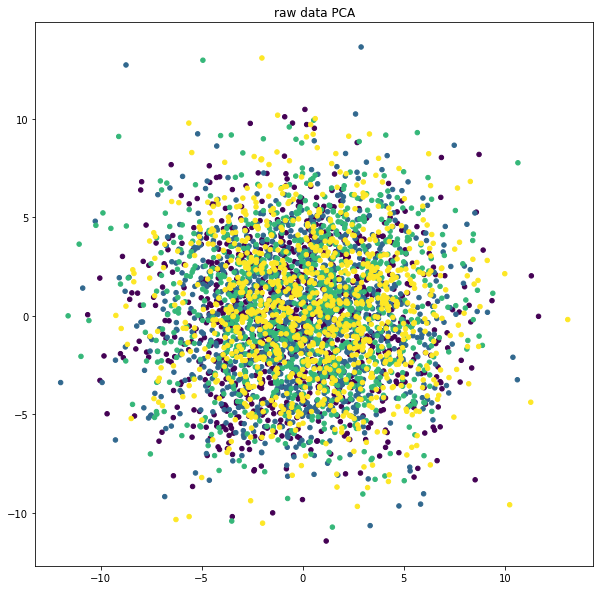

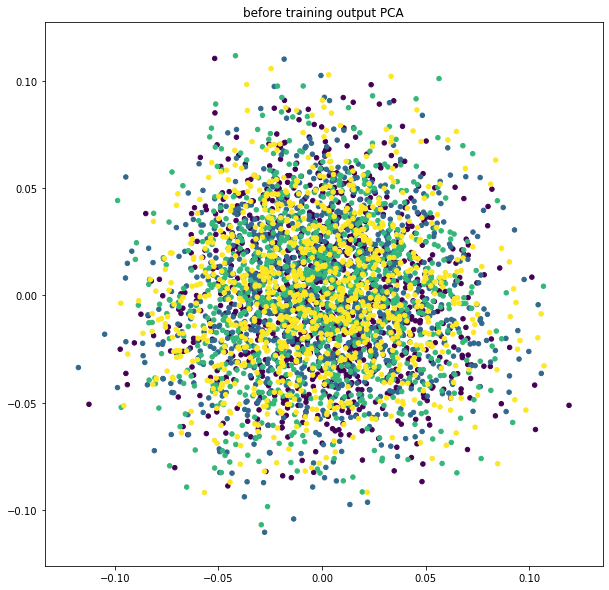

feature weight distribution: before training
layer0: 0.04438028857111931, [0.007309115957468748, 0.015252550132572651, 0.012563885189592838, 0.009254743345081806]
overall: 0.04438029208277542, [0.007309115538829373, 0.015252549258962479, 0.01256388446997954, 0.009254742815004026]


ValueError: 'c' argument has 42 elements, which is not acceptable for use with 'x' with size 82, 'y' with size 82.

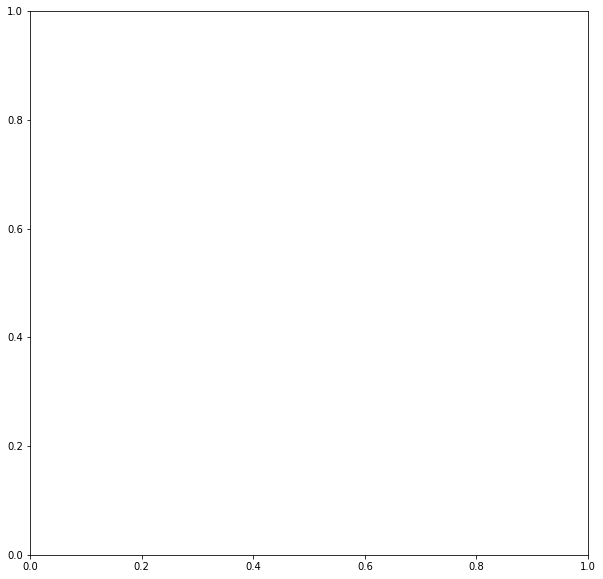

In [71]:
x_var = Variable(torch.from_numpy(x).float())
y_var = Variable(torch.from_numpy(y).long())
num_cls = y_var.data.max().item() + 1

train_portions = [0.005, 0.01, 0.1, 0.2, 0.5, 0.8]
res = {}

for train_portion in train_portions:
  proportions = [train_portion]*num_cls
  x_train, y_train, x_test, y_test, train_idx, test_idx = split_data(
      x_var, y_var, proportions=proportions, seed=seed)
  print('train size: {0}, test size: {1}'.format(y_train.size(0), y_test.size(0)))

  data = {'X_train':x_train.data, 'y_train':y_train.data, 'X_val':x_test.data, 'y_val':y_test.data, 
         'X_test':x_test.data, 'y_test':y_test.data}
  save_folder = '{0}/train_portion-{1}/'.format(save_folder_prefix, train_portion)
  
  res[train_portion] = compare_classifiers(x_train.data.numpy(), x_test.data.numpy(), 
                                          y_train.data.numpy(), y_test.data.numpy(), 
                                           names, classifiers)
  eval_affinitynet(data, res)

if not os.path.exists(save_folder_prefix):
  os.mkdir(save_folder_prefix)
with open('{0}/res.pkl'.format(save_folder_prefix), 'wb') as f:
  pickle.dump(res, f)
  
# with open(save_folder_prefix+'res.pkl', 'rb') as f:
#   data = pickle.load(f)